MODULE 3 | LESSON 2


---

# **Efficient Frontier, Sharpe Ratio and Downside Risk Metrics**

|  |  |
|:---|:---|
|**Reading Time** | 6h  |
|**Prior Knowledge** | percent-log returns, risk metrics, normal and t distributions  |
|**Keywords** | dividend adjusted, adjusted close, splits, returns, Value at Risk, Conditional, expectation |

---

*In this lesson, we continue by exploring some important types of returns.  Specifically, we introduce total returns, dividend-adjusted returns, and excess returns. We discuss the adjusted close price and give direction on how to calculate it. We then progress to the Sharpe Ratio, a fundamental metric in modern portfolio theory that measures risk-adjusted performance. This ratio helps investors and analysts evaluate the return of an investment in relation to its risk. Lastly, we introduce the Value at Risk (VaR), a key risk metric used widely in the financial industry. We cover multiple methods for calculating VaR, including historical, parametric (using both normal and t-distributions), and Monte Carlo simulation approaches. We also introduce the concept of Conditional Value at Risk (CVaR), which provides additional insight into tail risk.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import fredapi as fa
from scipy import stats
import numpy as np
sns.set()

## **1. Total Returns and Dividend-Adjusted Returns**

In the previous lesson, we discussed on portfolio returns and variance. We specifically learned how to calculate returns and annualize them along with some specific characteristics of the two major kinds of returns: percent and logarithmic.

In this lesson, we start by expanding on **total, dividend-adjusted, and excess Returns** as a prerequisite for various kinds of ratios an engineer should be aware of. In doing so, a discussion on *adjusted close price* will naturally emerge.

### **1.1 Total Returns & Dividend Adjusted Returns**

Total returns represent the overall gain or loss on an investment over a specific period. It accounts for all forms of income:

$$
\text{Total Returns} = \frac{(p_{T} - p_{0}) + (D + I)}{p_{0}}
$$

Where:
* $T$: End of period.
* $D$: Dividends.
* $I$: Any form of additional income the specific investment provides.

Dividend-adjusted returns are similar to total returns except they only account for dividends paid:

$$
\text{Dividend Adjusted Returns} = \frac{(p_{T} - p_{0}) + D}{p_{0}}
$$

The above two formulae are self-explanatory and intuitive, but in order to dive a bit deeper, we will need to calculate them given a close price and the dividends per share.

Let's consider a stock X with the following close price and dividends over three years (all prices are ex-date):

|  |  | |
|---   |---|  ---|
| Year | Price (\$) | Dividends(\$) |
| 2019: | 105 | 2 |
| 2020: | 112 | 2.2 |
| 2021: | 118 | 2.4 |
| 2022: | 116 | 2.3 |

The dividend-adjusted returns for the period 2021 to 2022 are:

$$
r^{\text{Adj}}_{2021 - 2022} = \frac{116 - 118 + 2.3}{118} = 0.0025
$$

whereas the non-adjusted returns are:

$$
r_{2021 - 2022} = \frac{116 - 118}{118} = -0.017
$$

Even though the two returns are pretty close, their sign is different! And since every investor that holds shares will get paid dividends, we need to take this into account as well in calculating returns. The latter leads us to the adjusted-close price as a convenient price transformation that takes dividends into account (along with splits and other corporate actions)

### **1.2 Adjusted-Close Price**

A simple way of calculating the adjusted-close (assuming no splits) is the following:

$$
p^{\text{adj}}_{t} = p_{t}^{\text{close}} - \sum_{i > t} D_{i}
$$

which essentially means that at any given time $t$, we need to subtract all dividends that are paid from time $t$ and on. Calculating the adjusted-close is a backwards-looking procedure. For example:

|  |  | | |
|---   |---|  ---| ---|
| Year | Close Price (\$) | Dividends(\$) | Adjusted Close (\$)|
| 2019: | 105 | 2 | 105 - 2.2 - 2.3 - 2.4 = 98.10 |
| 2020: | 112 | 2.2 | 112 - 2.3 - 2.4  = 107.30|
| 2021: | 118 | 2.4 | 118 - 2.3 = 115.07 |
| 2022: | 116 | 2.3 | 116 |

So now, let's calculate the dividend-adjusted returns and the adjusted-close returns over the period of 2019 to 2021.

$$
\text{Dividend Adjusted Returns} = \frac{(118 - 105) + 2.4 + 2.2}{105} = 0.1676
$$

and

$$
\text{Adjusted Close Returns} = \frac{115.07 - 98.10}{98.10} = 0.1723
$$

The above two numbers are different. Do you know why?

The reason lies in the reinvestment assumption when calculating the adjusted-close price. One can see that this transformation leads to significant changes in the price array: for 2019, the observed price was 105 whereas the adjusted-close was 98.10. Similarly, for 2021, the observed price was 118 while the adjusted-close was 115.07. The difference between the two adjusted-close prices is attributed to price appreciation (the same as with the close prices) and the dividends paid during that period. In essence, the share's close price along with the dividends **is replicated with a price that incorporates the dividends as if the latter was a part of price appreciation**.

But if the price of an asset one holds appreciates, then the appreciation is still part of the asset and not cash as is the case when dividends are paid. In this observation, we find an important distinction between the dividend-adjusted returns and adjusted-close returns: when using adjusted-close returns, we assume that we reinvest the dividends in more shares.

For a more detailed and precise way of calculating the adjusted close, please read this: https://help.yahoo.com/kb/SLN28256.html?guccounter=1. Make sure you can explain the benefits of using multipliers instead of subtracting the dividends in adjusting the price.

-----------

**Exercise 1**

Given an additional data point for stock X:

|  |  | |
|---   |---|  ---|
| Year | Price (\$) | Dividends(\$) |
| 2023: | 120 | 1.8 |

answer whether the close price for 2020 will change. What about the existing adjusted close price for 2020? By how much? (Use the method provided in the notebook.)

-----------------

Now, let's showcase an example of calculating the adjusted-close price for TSLA, which had two splits but never paid dividends (make sure you understand the method explained in the link above).


# Exercise 1
Close price for 2020 will not change. Historical market prices are immutable and wont change because new data is added.Adjusted close will decrease by $1.80

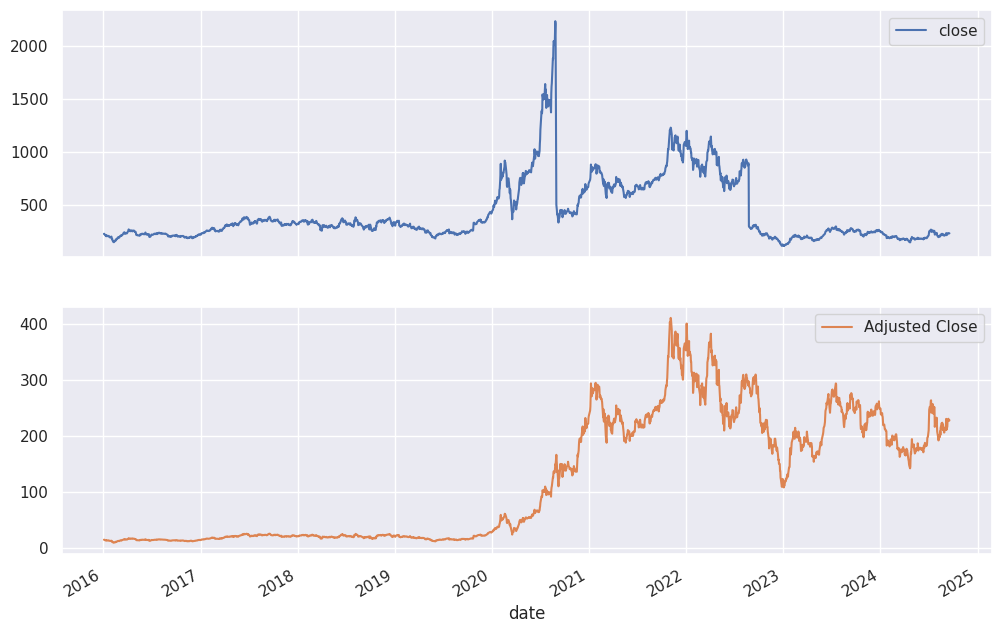

In [2]:
# Figure 1
tsla = pd.read_csv("https://raw.githubusercontent.com/DonLeKouT/Just_files/refs/heads/main/TSLA_stock_price.csv")
tsla.set_index('date', inplace=True)
tsla.index = pd.to_datetime(tsla.index)

splits = {'2022-08-25' : 3, "2020-08-31" : 5} # The dates and multiplier of TSLA splits

tsla['Adjusted Close'] = tsla['close'].copy()

for date, split in splits.items():
    date = pd.to_datetime(date) - pd.Timedelta(days=1)
    tsla.loc[:date, 'Adjusted Close'] = tsla.loc[:date, 'Adjusted Close'] / split

tsla[['close', 'Adjusted Close']].loc["2016":].plot(figsize=(12, 8), subplots = True)
plt.show()


In Figure 1, one can see the differences between the close and the adjusted-close price. We notice the divergence in scale ($y$-axis), which is proportional to the splits. Additionally, in the close price plot, we observe the vertical decline in price on the days the split happened. That is to be expected since the split kept the market cap of TSLA intact, lowering the price of the share in an instant.

--------

**Exercise 2**

Compute the daily returns (percent or log) of the close and adjusted-close price of TSLA. Are they different?


**Exercise 3**

Create an account in AlphaVantage and obtain an APIKEY. Select an asset that had undergone several splits (2 or more) and paid some dividends (twice or more) and download the close price (not adjusted). Use the Yahoo methodology, found in the link provided above, in order to calculate the adjusted-close price. Plot the results as in Figure 1.

-------



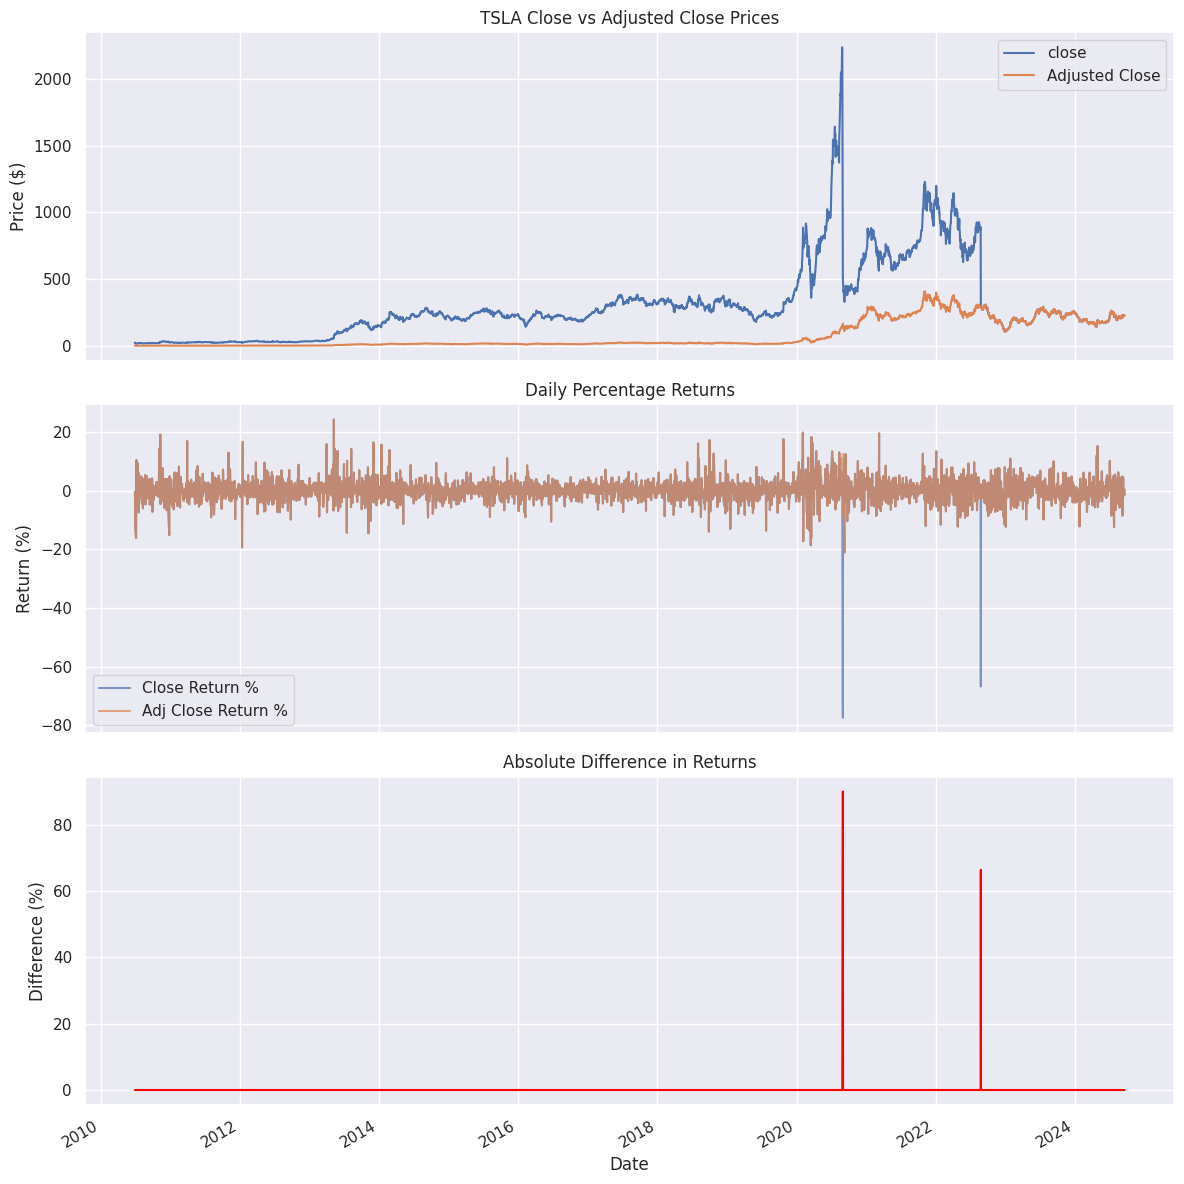

Days with return differences > 0.01%: 2
Maximum return difference: 90.05511882172223 %


In [3]:
# Exercise 2

# Load and prepare data
tsla = pd.read_csv("https://raw.githubusercontent.com/DonLeKouT/Just_files/refs/heads/main/TSLA_stock_price.csv")
tsla.set_index('date', inplace=True)
tsla.index = pd.to_datetime(tsla.index)

# Apply stock split adjustments
splits = {'2022-08-25': 3, "2020-08-31": 5}
tsla['Adjusted Close'] = tsla['close'].copy()

for date, split in splits.items():
    adjustment_date = pd.to_datetime(date) - pd.Timedelta(days=1)
    tsla.loc[:adjustment_date, 'Adjusted Close'] /= split

# Compute returns
tsla['Close Return %'] = tsla['close'].pct_change() * 100
tsla['Adj Close Return %'] = tsla['Adjusted Close'].pct_change() * 100
tsla['Close Log Return'] = np.log(tsla['close']).diff()
tsla['Adj Close Log Return'] = np.log(tsla['Adjusted Close']).diff()

# Compare returns
return_comparison = tsla[['Close Return %', 'Adj Close Return %']].copy()
return_comparison['Difference %'] = return_comparison['Close Return %'] - return_comparison['Adj Close Return %']
return_comparison['Absolute Difference %'] = return_comparison['Difference %'].abs()

# Plot results
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Price comparison
tsla[['close', 'Adjusted Close']].plot(ax=axes[0], title='TSLA Close vs Adjusted Close Prices')
axes[0].set_ylabel('Price ($)')

# Return comparison
tsla[['Close Return %', 'Adj Close Return %']].plot(ax=axes[1], alpha=0.7, title='Daily Percentage Returns')
axes[1].set_ylabel('Return (%)')

# Difference visualization
return_comparison['Absolute Difference %'].plot(ax=axes[2], color='red', title='Absolute Difference in Returns')
axes[2].set_ylabel('Difference (%)')
axes[2].set_xlabel('Date')

plt.tight_layout()
plt.show()

# Print key metrics
print("Days with return differences > 0.01%:", (return_comparison['Absolute Difference %'] > 0.01).sum())
print("Maximum return difference:", return_comparison['Absolute Difference %'].max(), "%")

In [4]:
# Execise 3
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime

# Alpha Vantage API configuration
API_KEY = "XR8ET32HN66Y5X9R"
SYMBOL = "AAPL"  # Apple has multiple splits and dividends
FUNCTION = "TIME_SERIES_DAILY_ADJUSTED"

# Fetch data from Alpha Vantage
url = f"https://www.alphavantage.co/query?function={FUNCTION}&symbol={SYMBOL}&apikey={API_KEY}&outputsize=full"
response = requests.get(url)
data = response.json()

# Extract time series data
ts_data = data.get("Time Series (Daily)", {})
if not ts_data:
    raise ValueError("No daily data found in API response")

# Prepare data lists
dates = []
closes = []
dividends = []
splits = []

# Parse daily data
for date_str, daily_data in ts_data.items():
    dates.append(datetime.strptime(date_str, "%Y-%m-%d"))
    closes.append(float(daily_data["4. close"]))
    dividends.append(float(daily_data["7. dividend amount"]))
    splits.append(float(daily_data["8. split coefficient"]))

# Create DataFrame
df = pd.DataFrame({
    "date": dates,
    "close": closes,
    "dividend": dividends,
    "split": splits
}).sort_values("date").reset_index(drop=True)

# Initialize adjusted close with unadjusted values
df["Adjusted Close"] = df["close"].copy()

# Identify split events (where split coefficient ≠ 1)
split_events = df[df["split"] != 1.0][["date", "split"]]

# Apply split adjustments backward from each split date
for _, row in split_events.iterrows():
    split_date = row["date"]
    split_factor = row["split"]
    adjustment_date = split_date - pd.Timedelta(days=1)
    df.loc[df["date"] <= adjustment_date, "Adjusted Close"] /= split_factor

# Identify dividend events (where dividend > 0)
dividend_events = df[df["dividend"] > 0][["date", "dividend"]]

# Apply dividend adjustments backward from each dividend date
for _, row in dividend_events.iterrows():
    div_date = row["date"]
    dividend_amount = row["dividend"]
    adjustment_date = div_date - pd.Timedelta(days=1)
    
    # Find cumulative split factor after dividend date
    subsequent_splits = split_events[split_events["date"] > div_date]
    cumulative_split = subsequent_splits["split"].prod() if not subsequent_splits.empty else 1.0
    
    # Apply dividend adjustment
    df.loc[df["date"] <= adjustment_date, "Adjusted Close"] -= dividend_amount * cumulative_split

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(df["date"], df["close"], label="Unadjusted Close", alpha=0.7)
plt.plot(df["date"], df["Adjusted Close"], label="Adjusted Close", alpha=0.7)
plt.title(f"{SYMBOL} Stock Price: Adjusted vs Unadjusted")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

ValueError: No daily data found in API response

## **2.  Excess Returns**

### **2.1 Excess Returns Definition**

As you already remember from the Financial Markets course, excess return is the difference between the returns of an asset (or portfolio) and a benchmark. An analyst can use various benchmarks depending on the analysis, but the most common ones are a market proxy (S&P500) or a risk-free rate (T-Bills). The formula for excess returns is:

$$
\text{Excess Returns} = r_{\text{portfolio}} - r_{\text{benchmark}}
$$

where:
* $r_{\text{portfolio}}$ is the **total return** of the investment
* $r_{\text{benchmark}}$ is the returns of the benchmark

In calculating excess returns, it is crucial to account for all types of cash flows associated with the investment, which is why total returns are used. In practice, however, adjusted-close returns can be used, provided that any additional cash flows are manually included if they are not already factored into the adjusted-close price by the data provider.

But now, we need to talk about the benchmark. As we have mentioned, the benchmark is case specific and can be represented by any asset an analyst decides to test the returns of their investment against. For example:

* Selecting a benchmark in terms of objectives, strategy, and sector: S&P500 as a broad market benchmark, NASDAQ for technology and growth portfolios, or Russell 2000 for small-cap equity portfolios.

* Geographic exposure: the benchmark should represent the region where the investment takes place. In the UK, one could use FTSE 100 or FTSE 250; in the EU, there is EURO STOXX 50, DAX, or CAC 40; and in India, one has NIFTY 50, S&P BSE 500, and more.

* Using the risk-free rate as the benchmark, one should take into account the:

  * Investment horizon: for short-term investments, government securities like 3-month T-bill are appropriate. For longer-term investments, 10-year treasuries could be more suitable. In any case, the rule of thumb is to use the rate that is the closest to the duration of the investment.

  * Theoretical considerations: the 3-month T-bill is widely used in academic studies and models like CAPM, but the 10-year Treasury better represents the expectations for inflation and the economy.

### **2.2 Excess Returns over Expected Return**

In the context of finance, the expected return of an asset represents the return an investor expects/requires given the risk profile of the specific asset. That means that in calculating the expected return, one can take into account the systematic risk, inflation expectations, interest rate risk, and more. If the actual returns of the asset are greater than expected returns, then we can say that *the asset has outperformed expectations*.

$$
\text{Excess Returns} = r_{\text{actual}} - \mathbb{E}(r_{\text{asset}})
$$

But calculating the expected return is not straightforward and depends on several strong assumptions. We will mention several methods used to estimate the expected returns of an asset. These methods are distinguished with respect to the types of risk that they make use of:

**CAPM**

A widely used model is the capital asset pricing model (CAPM), which models returns with respect to systematic risk. The formula for CAPM is:

$$
\mathbb{E}(r_{\text{asset}}) = r_{f} + \beta (r_{m} - r_{f})
$$

where
* $r_{f}$ is the risk-free rate
* $r_{m}$ is a market proxy
* $\beta$ is the sensitivity of the asset to the market returns.

In the CAPM world, the excess return is often called *alpha* ($\alpha$):

$$
\alpha = r_{\text{actual}} - \left ( r_{f} + \beta (r_{m} - r_{f}) \right )
$$

**APT**

The arbitrage pricing theory (APT) goes beyond the CAPM model in incorporating multiple factors of risk instead of just the systematic one (market). These factors could be any macroeconomic variable such as inflation, interest rates, economic growth, etc. The formulation is:

$$
\mathbb{E}(r_{\text{asset}}) = r_{f} + \beta_{1} f_{1} + \beta_{2} f_{2}+ \dots + \beta_{n} f_{n}
$$

where
* $f_{i}$ are the factor risk premiums
* $\beta_{i}$ are the sensitivities of the asset to these factors.

**Fama-French Three-Factor Model**

This model extends CAPM by adding two additional factors:
1. The *SMB* (small minus big) factor, which represents the "size premium." This is essentially the difference between small-cap and large-cap stocks.
2. The *HML* (high minus low) factor, which measures the difference between the returns of the value and growth stocks.

As with the CAPM and APT models, Fama-French also assumes linearity between expected returns and factors:

$$
\mathbb{E}(r_{\text{asset}}) = r_{f} + \beta_{\text{market}} (r_{m} - r_{f}) + \beta_{size} \cdot \text{SMB} + \beta_{\text{value}} \cdot \text{HML}
$$

The three models above were merely mentioned to explain the notion of expected returns and its importance in calculating excess returns. Essentially, excess returns measure performance over a chosen benchmark, which can be an external index or the asset's own expected return based on models like CAPM or APT.


## **3. Portfolio Sharpe Ratio and the Efficient Frontier**
We have already mentioned what the Sharpe ratio is in the previous module. We will now illustrate the importance of the Sharpe ratio in the context of portfolio management. In order to do so, we will assume the assets of Lesson 1, and we will show where the highest Sharpe ratio portfolios are located with respect to the efficient frontier.

In [5]:
assets = ['MSFT', 'AAPL', 'AMZN', 'TSLA', 'GOOGL'] # Assets for portfolio

asset_prices = yf.download(assets, start='2018-01-01', end='2023-01-01', auto_adjust = False)['Adj Close'] # Downloading daily data
asset_prices.index = pd.to_datetime(asset_prices.index.date)

# Download risk-free rate data (3-month Treasury bill)
risk_free = yf.download('^IRX', start='2018-01-01', end='2023-01-01', auto_adjust = False)['Adj Close']
risk_free.index = pd.to_datetime(risk_free.index.date)


r = asset_prices.pct_change().dropna() # Calculating daily percent returns

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


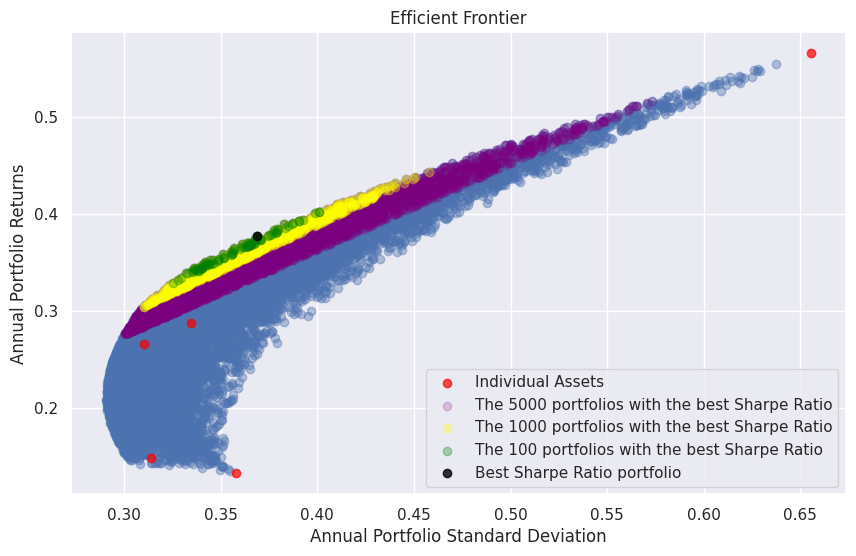

In [6]:
# Figure 2
weights = np.random.dirichlet(np.ones(5)*0.7, size = 20000) # Creating 20000 sets of weights using dirichlet distribution

assert np.isclose(np.sum(weights, axis = 1), 1).all() # Check that each set of weights sum up to 1

eff_front_dict = {}
cov_matrix_ret = r.cov() * 252
expected_returns = r.mean() * 252
risk_free_rate = risk_free['^IRX'].mean() / 100 # The rates are already annualized

# Filling the eff_front_dict
for w in weights:
  port_ret = expected_returns @ w.T # Annualized percent returns as expected returns
  port_std = np.sqrt(w.T @ cov_matrix_ret @ w)
  sharpe_ratio = (port_ret - risk_free_rate) / port_std
  eff_front_dict[str(list(w))] = [port_ret, port_std, sharpe_ratio]

eff_frontier_dataframe = pd.DataFrame(eff_front_dict, index = ['Returns', 'Standard Deviation', 'Sharpe Ratio']).T # Storing everything in one dataframe
highest_sharpe_ratio = eff_frontier_dataframe.sort_values(by = 'Sharpe Ratio', ascending = False) # Sorting the portfolios with respect to Sharpe Ratio

# Plot the portfolio returns vs portfolio variance
plt.figure(figsize = (10,6))
plt.scatter(x = eff_frontier_dataframe['Standard Deviation'], y = eff_frontier_dataframe['Returns'], alpha = 0.4)
plt.scatter(x = r.std() * np.sqrt(252), y = expected_returns, color = 'red', label = "Individual Assets", alpha = 0.7)
plt.scatter(x = highest_sharpe_ratio[:5000]['Standard Deviation'], y = highest_sharpe_ratio[:5000]['Returns'], color = 'purple', alpha = 0.2, label = "The 5000 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio[:1000]['Standard Deviation'], y = highest_sharpe_ratio[:1000]['Returns'], color = 'yellow', alpha = 0.3, label = "The 1000 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio[:100]['Standard Deviation'], y = highest_sharpe_ratio[:100]['Returns'], color = 'green', alpha = 0.3, label = "The 100 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio.iloc[0,:]['Standard Deviation'], y = highest_sharpe_ratio.iloc[0,:]['Returns'], color = 'black', alpha = 0.8, label = "Best Sharpe Ratio portfolio" )

plt.title("Efficient Frontier")
plt.xlabel("Annual Portfolio Standard Deviation")
plt.ylabel("Annual Portfolio Returns")
plt.legend()
plt.show()

What we essentially see in Figure 2 is the efficient frontier, as explained in the previous lesson, onto which we have additionally plotted the highest Sharpe Ratio portfolios.

More specifically, we illustrate where the 5000, 1000, and 100 portfolios with the highest Sharpe ratios are located and of course where the best Sharpe ratio portfolio is. As expected (?), those portfolios are on or very close to the efficient frontier, but to our surprise, they do not occupy the entire efficient frontier curve.

-------------

**Exercise 4**

Explain why we expect that the best Sharpe ratio portfolio will be on the efficient frontier.

**Exercise 5 (for discussion)**

Use the `highest_sharpe_ratio` dataframe and print the 10 portfolios with the highest Sharpe ratio. If you look at the weights closely, you will observe that while the Sharpe ratios between these portfolios are very similar, the weights vary a lot. For example, the weight for the 1st asset in the 8th portfolio is 44.8%, but the weight for the same asset in the 7th portfolio is 18.7%. However, the difference in their Sharpe ratios is minimal. Think it over and then discuss with your peers in the forum the implications of the above observation on portfolio management: that several very different portfolios have almost identical Sharpe ratios.

------------



## Exercise 4
Why the Best Sharpe Ratio Portfolio Must Lie on the Efficient Frontier
The efficient frontier represents the set of optimal portfolios that offer:

Maximum expected return for a given level of risk

Minimum risk for a given level of expected return

The Sharpe ratio ($SR = \frac{R_p - R_f}{\sigma_p}$) measures excess return per unit of risk. 
The portfolio with the highest Sharpe ratio (the tangency portfolio) must lie on the efficient frontier due to 
these mathematical and economic reasons:

1. Mathematical Necessity
The efficient frontier is the upper boundary of all possible portfolios in risk-return space

Any portfolio below the efficient frontier is dominated (either higher risk for same return or lower return for same risk)

The tangency portfolio maximizes the slope of the capital allocation line (CAL).

This optimization problem's solution must lie on the efficient frontier by definition



In [19]:
import pandas as pd
import ast

# Extract top 10 portfolios
top_10 = highest_sharpe_ratio.head(10).copy()

# Parse weight strings into lists
top_10['Weights'] = top_10.index.map(lambda x: ast.literal_eval(x))

# Create columns for each asset weight
assets = ['MSFT', 'AAPL', 'AMZN', 'TSLA', 'GOOGL']
for i, asset in enumerate(assets):
    top_10[asset] = top_10['Weights'].apply(lambda w: w[i])

# Format and display relevant columns
cols = ['Returns', 'Standard Deviation', 'Sharpe Ratio'] + assets
display(top_10[cols].style.format({
    'Returns': '{:.2%}',
    'Standard Deviation': '{:.2%}',
    'Sharpe Ratio': '{:.3f}',    **{asset: '{:.1%}' for asset in assets}
}))

,Returns,Standard Deviation,Sharpe Ratio,MSFT,AAPL,AMZN,TSLA,GOOGL
"[0.32157173953007107, 0.00021531472596852114, 0.003521320755908784, 0.32582310232528855, 0.34886852266276314]",37.68%,36.85%,0.988,32.2%,0.0%,0.4%,32.6%,34.9%
"[0.37753077410414604, 0.0010612188541193526, 0.007436584616031795, 0.35531965624716727, 0.2586517661785355]",35.04%,34.20%,0.988,37.8%,0.1%,0.7%,35.5%,25.9%
"[0.33444452904800787, 0.005142650014982205, 0.007599422999082092, 0.326662042869474, 0.3261513550684538]",36.91%,36.12%,0.987,33.4%,0.5%,0.8%,32.7%,32.6%
"[0.31379255170725495, 0.00586174588410634, 0.00893580836854119, 0.37668212324404915, 0.2947277707960483]",35.90%,35.10%,0.987,31.4%,0.6%,0.9%,37.7%,29.5%
"[0.3916562260193567, 0.0016068169882054574, 0.0010922615322666437, 0.3711122754688981, 0.2345324199912731]",34.42%,33.62%,0.986,39.2%,0.2%,0.1%,37.1%,23.5%
"[0.28894866506378003, 0.008925480892107644, 0.00610470378401825, 0.3809843183992018, 0.31503683186089226]",36.45%,35.68%,0.986,28.9%,0.9%,0.6%,38.1%,31.5%
"[0.38618357133012904, 0.009143777118256077, 0.004971305803572871, 0.3324204438530778, 0.26728090189496423]",35.24%,34.47%,0.986,38.6%,0.9%,0.5%,33.2%,26.7%
"[0.22788583063438952, 0.0007988061376985988, 0.006791098562312712, 0.5003955653019001, 0.26412869936369904]",34.89%,34.14%,0.985,22.8%,0.1%,0.7%,50.0%,26.4%
"[0.3284029722059337, 0.000333209468968497, 0.0001032502670344648, 0.28155614479163465, 0.3896044232664285]",38.95%,38.29%,0.984,32.8%,0.0%,0.0%,28.2%,39.0%
"[0.3163069110687822, 0.01515297164253539, 0.003635298499066524, 0.39838476816770263, 0.2665200506219132]",35.00%,34.29%,0.984,31.6%,1.5%,0.4%,39.8%,26.7%


## **4. The Tangency Portfolio and the Tangent Line**

Given the above observations, we can now give a definition for the best Sharpe ratio portfolio: the best Sharpe ratio portfolio, or the tangency portfolio, is the one that maximizes returns per unit of risk. **It provides the best risk-return tradeoff among all portfolios** (Elton et al.).

Our discussion and illustrations of portfolios' efficient frontiers give the impression that the efficient frontier contains optimal portfolios. In the next section, we will discuss the capital market line in order to illustrate how the tangency portfolio along with the risk-free rate can be used in creating a series of portfolios that are superior to the efficient frontier.

The tangent line, or the capital market line, is a key concept that arises from combining a risk-free asset with the tangency portfolio. Mathematically, the CML formulation is:

$$
r_{\text{CML}} = r_{f} + \frac{r_{T} - r_{f}}{\sigma_{T}} \cdot \sigma_{P}
$$

where
* $r_{\text{CML}}$ is the expected return of any portfolio on the CML
* $r_{T}$ is the return of the tangency portfolio (best Sharpe ratio portfolio)
* $\sigma_{T}$ is the std of the tangency portfolio
* $\sigma_{p}$ is the std of any portfolio on the CML

Let's visualize the CML before providing some intuition behind its use:

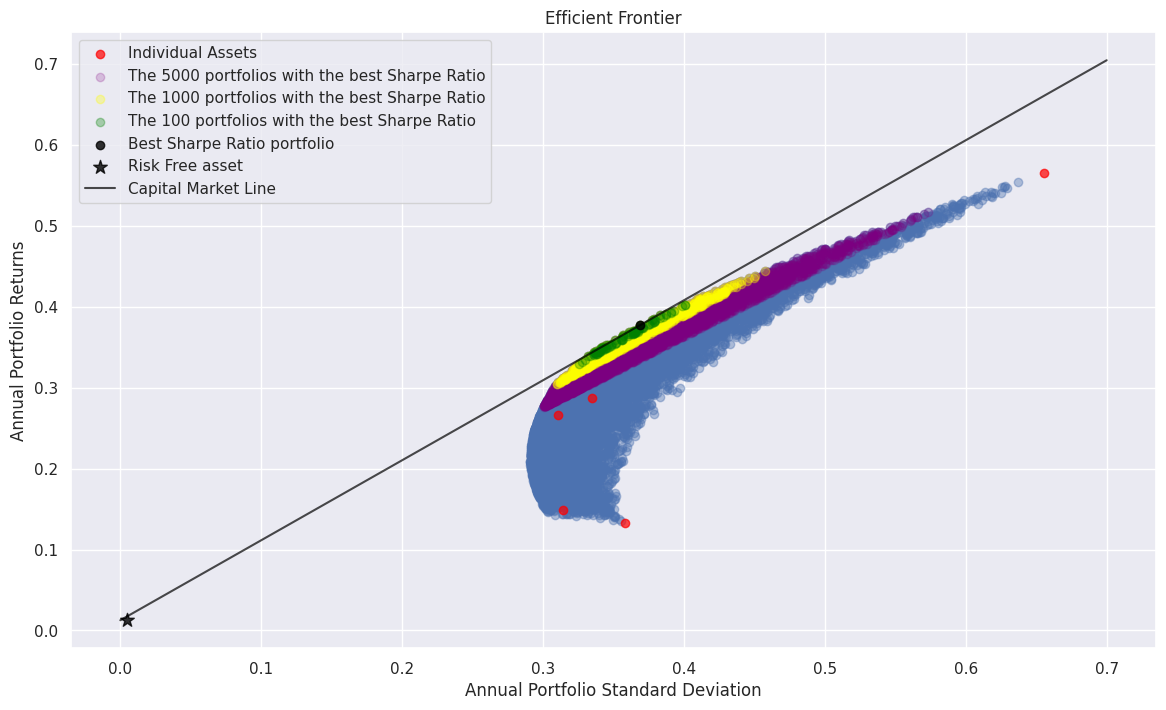

In [7]:
sigmas = np.linspace(0,0.7, 100)
CML = risk_free_rate + highest_sharpe_ratio['Sharpe Ratio'].iloc[0] * sigmas # This is the Capital Market Line

# Plot the portfolio returns vs portfolio variance
plt.figure(figsize = (14,8))
plt.scatter(x = eff_frontier_dataframe['Standard Deviation'], y = eff_frontier_dataframe['Returns'], alpha = 0.4)
plt.scatter(x = r.std() * np.sqrt(252), y = expected_returns, color = 'red', label = "Individual Assets", alpha = 0.7)
plt.scatter(x = highest_sharpe_ratio[:5000]['Standard Deviation'], y = highest_sharpe_ratio[:5000]['Returns'], color = 'purple', alpha = 0.2, label = "The 5000 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio[:1000]['Standard Deviation'], y = highest_sharpe_ratio[:1000]['Returns'], color = 'yellow', alpha = 0.3, label = "The 1000 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio[:100]['Standard Deviation'], y = highest_sharpe_ratio[:100]['Returns'], color = 'green', alpha = 0.3, label = "The 100 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio.iloc[0,:]['Standard Deviation'], y = highest_sharpe_ratio.iloc[0,:]['Returns'], color = 'black', alpha = 0.8, label = "Best Sharpe Ratio portfolio" )
plt.scatter(x = (risk_free / 252).std(), y = risk_free_rate, color = 'black', alpha = 0.8, marker = '*', label = "Risk Free asset", s = 105)
plt.plot(sigmas, CML, color = 'black', label = "Capital Market Line", alpha = 0.7)


plt.title("Efficient Frontier")
plt.xlabel("Annual Portfolio Standard Deviation")
plt.ylabel("Annual Portfolio Returns")
plt.legend()
plt.show()

First of all, we need to observe that **the slope of the CML line is the Sharpe ratio** of the tangency portfolio and that the CML represents a crucial improvement over the efficient frontier. But how are the portfolios of the CML constructed? Let's rearrange the CML formulation as such:

$$
r_{\text{CML}} = r_{f} \left ( 1 - \frac{\sigma_{P}}{\sigma_{T}} \right ) + r_{T} \left ( \frac{\sigma_{P}}{\sigma_{T}} \right )
$$

Simply by combining the risk-free asset with the tangency portfolio and assigning the next weights:
* Tangency portfolio weight: $w_{T} = \frac{\sigma_{P}}{\sigma_{T}}$
* Risk-free weight: $w_{f} = 1 - \frac{\sigma_{P}}{\sigma_{T}}$

There will be more on this in the Portfolio Management course.

## **5. Value at Risk (VaR)**

Knowing the variance and standard deviation is a big help when it comes to risk. Doing so can help us calculate one of the several ways we can measure risk by using **Value at Risk**.

Value at Risk is one of the easiest risk metrics to interpret. So far, the metrics we have introduced quantify risk as a percentage, in the case of standard deviation, or in units, as the Sharpe ratio does. Value at Risk answers the fundamental question many investors have on their mind: how much can I lose on an investment in the worst-case scenario? This is measured in dollars for the purposes of this class.

Value at Risk measures the potential loss in value of an asset/portfolio over a defined time period. Basically, you will always need to specify the time period and confidence interval that accompanies a Value at Risk. For example, if the VaR of a portfolio is \\$1,000,000 over a yearly time period with a 99\% confidence interval, it would mean that the portfolio only has a 1\% chance of losing more than \\$1,000,000 for any given year. VaR has become ubiquitous over the years; every investment bank and risk management firm employs some form of VaR to help keep a cap on the potential losses one can incur. The focus on VaR is very much about downside risk unlike something like standard deviation, which looks at both the upside and downside risk.

There are three basic methods for calculating VaR, each with their own advantages and disadvantages. These build on some of the lessons from earlier, like variance and covariance. Keep in mind that there are countless variations of each basic method, but we will stick with these main three for now:

* Historical Method
* Parametric Method
* Monte Carlo Simulation

## **6. VaR Using the Historical Method**

This is probably the simplest and most intuitive method of calculating Value at Risk. In short, historical returns are sorted from lowest to highest on an asset or portfolio. Let's say you want to calculate the daily Value at Risk on an equity with a 95% confidence interval. Assuming we can look at the last thousand days of data for this stock, we would take the daily returns and sort them from lowest to highest. From here, we would take the return from the 5th percentile of the data. In this case, with 1,000 days of data, it would be the 50th (0.05\*1000) worst daily return from these thousand days. Let's say the 50th worst day had a –4% return. From this, we can assume that the daily VaR for this stock with a 95% confidence interval is –4%. Building on that, if we were to invest \\$1,000 in said stock, we would expect the worst daily loss to be:

-0.04\*1000 = -\\$40  with a 95% confidence interval

Considerations for this method:

* This method uses historical returns to measure VaR empirically, which means that there are no assumptions made about the distribution whereas many models assume the normal distribution.
* Each day for this method is given equal weight, which means if there is a trend in the volatility, you could be overstating or understating the VaR depending on whether the volatility trend is down or up, respectively. One refinement to combat this could be to place greater weight on more recent data.
* Past data does not necessarily indicate what will happen in the future. While the other methods also rely on historical data to a certain extent, this method is solely derived from past historical returns. There are many unforeseen events that can happen, which can change the course of a stock's trajectory and cause the stock to trade differently than it did in the past.

### **6.1 Implementing Value at Risk (VaR) - Historical Method**

Calculating daily historical VaR can be done pretty simply in Python. The order of steps needed is as follows:
1. Calculate all daily returns.
2. Sort these returns from least to greatest.
3. Based on a given confidence level, return the corresponding percentile return. In other words, if we want to calculate daily VaR at a 95% confidence level and we are using 100 data points, the 5th smallest return of that sample would be considered our 95% VaR.

Let's visualize this first with a histogram using Bitcoin.

[*********************100%***********************]  1 of 1 completed


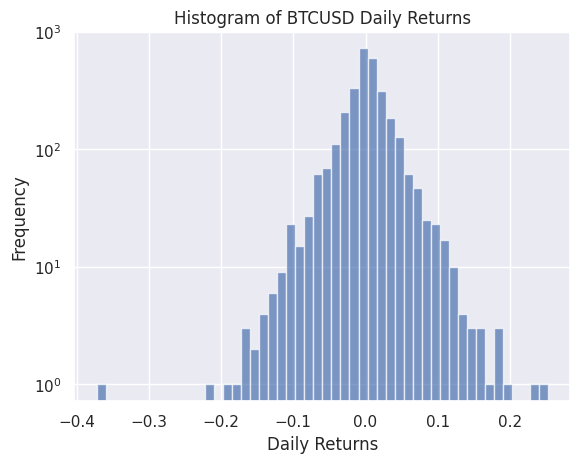

In [8]:
# Figure 1
btcusd = yf.download("BTC-USD", start="2014-09-18", end="2022-12-31", auto_adjust = False)['Adj Close']
btcusd_returns = btcusd.pct_change().dropna()

plt.hist(x = btcusd_returns, bins=50, log = True, alpha = 0.7)
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title('Histogram of BTCUSD Daily Returns')
plt.show()

In order to have a better visualization of the extreme events, we used a logarithmic scale for the $y$ axis. Let's calculate the historical VaR from this data.

The next function `getHistoricalVar()` takes two arguments:
1. a series of daily returns
2. a confidence level, 95 for example, would correspond to 95% confidence

In [9]:
def getHistoricalVar(returns, confidenceLevel):
    var = np.quantile(returns, 1 - confidenceLevel)
    print(
        f"The Historical VaR with confidence {confidenceLevel} is {round(100 * var, 3)}% \n"
    )

getHistoricalVar(btcusd_returns, 0.90)
getHistoricalVar(btcusd_returns, 0.95)
getHistoricalVar(btcusd_returns, 0.99)

The Historical VaR with confidence 0.9 is -3.717% 

The Historical VaR with confidence 0.95 is -6.0% 

The Historical VaR with confidence 0.99 is -10.57% 



After running the function, we can see that the greater we make our confidence level, the lower the Value at Risk will be. This is a useful tool when determining how much a financial asset can lose over a certain time period.

You may be wondering now, since we only use a 95% confidence level, what happens on those 5% of days where losses exceed -6.02%. We can use another handy metric, Conditional Value at Risk (CVaR), to deal with these situations.

### **6.2 Conditional Value at Risk (CVaR) using Historical Data**

Conditional Value at Risk (CVaR), also known as Expected Shortfall (ES), is a widely used risk measure in financial risk management. While Value at Risk (VaR) estimates the loss over a specific time horizon given a confidence level (e.g., 99%), CVaR goes beyond VaR by providing the expected loss if the VaR is exceeded. In other words, CVaR calculates the average loss in the tail of the distribution beyond the VaR threshold.

Mathematically, the CVaR at confidence level $\alpha$ is:

$$
\text{CVaR}_{\alpha} = \mathbb{E}[L|L>\text{VaR}_{\alpha}]
$$

where $L$ represents the losses.

Historical CVaR is a non-parametric approach, which means that it does not rely on distribution assumptions for the returns. Instead, we can directly calculate the expectation of the losses after we have obtained the VaR. In practice, we can calculate the mean of the returns that are located to the left of the VaR.

In [10]:
def getHistoricalCVar(returns, confidenceLevel):
    var = np.quantile(returns, 1 - confidenceLevel)
    cvar = returns[returns <= var].mean()
    print(
        f"With {confidenceLevel} percent confidence VaR, our Expected Shortfall is {round(100 * cvar, 3)} using historical VaR \n"
    )

getHistoricalCVar(btcusd_returns, 0.90)
getHistoricalCVar(btcusd_returns, 0.95)
getHistoricalCVar(btcusd_returns, 0.99)

With 0.9 percent confidence VaR, our Expected Shortfall is Ticker
BTC-USD   -6.893
dtype: float64 using historical VaR 

With 0.95 percent confidence VaR, our Expected Shortfall is Ticker
BTC-USD   -9.017
dtype: float64 using historical VaR 

With 0.99 percent confidence VaR, our Expected Shortfall is Ticker
BTC-USD   -14.285
dtype: float64 using historical VaR 



## **7. VaR Using the Parametric Method**

Parametric VaR is a method of calculating Value at Risk assuming that the returns follow a specific probability distribution. In the standard variation, a normal distribution is assumed, but one can use other distributions as well, as we will see in the second example where we assume a t-distribution.

### **7.1 Normal Distribution Parametric VaR**

In the case of a normal distribution, the use of a Z-table is essential in calculating the VaR. While performing the task, we need to always take into account that the risk refers to the **left tail**.

$$
\text{VaR} = \mu + \sigma Z_{\alpha}
$$

where
* $\mu$ is the mean return
* $\sigma$ is the standard deviation of returns
* $Z_{\alpha}$ is the Z-score that corresponds to the confidence interval



Considerations for this method:

* If returns are not normally distributed, you will likely be underestimating the true Value at Risk. For example, many stocks have more outliers than the normal distribution would assume; this means the computed Value at Risk will be lower than what it is in actuality.
* Variance and covariance between return streams must be considered when computing VaR for a portfolio. Even if returns are normally distributed, the VaR calculation can still be thrown off if the estimated variances and covariances are incorrect. This can be further amplified if variances and covariances are changing over time.
* Models that allow variance to change over time (heteroskedasticity) display a greater degree of accuracy. Engle has argued that autoregressive conditional heteroskedasticity (ARCH) and generalized autoregressive conditional heteroskedasticity (GARCH) models provide better forecasts of variance and, by extension, better measures of Value at Risk.
* This method breaks down whenever a portfolio has assets with a non-linear payoff structure, e.g., options.

### **7.2 Implementing Parametric VaR with Normal Distribution**

While it's well-established that financial returns, particularly for equities, often exhibit non-normal characteristics, such as skewness and fat tails, this parametric approach still holds significant value in financial risk management. The normal distribution assumption provides an efficient way to estimate risk, making it highly useful in situations where quick approximations are needed or can be used in conjunction with other models.

To calculate Value at Risk (VaR) using the parametric method, we will leverage the `norm.ppf()` function from Python’s `scipy.stats` module. The percent point function (ppf) is actually the inverse cumulative distribution function (CDF), and it allows us to compute the quantile that corresponds to a given confidence level.

In [11]:
mean = btcusd_returns.mean()
std = btcusd_returns.std()

var_90 = stats.norm.ppf(0.1, mean, std)[0]
var_95 = stats.norm.ppf(0.05, mean, std)[0]
var_99 = stats.norm.ppf(0.01, mean, std)[0]

print(f"The parametric VaR assuming a normal distribution with a 90% confidence interval, is {round(100 * var_90, 3)} \n")
print(f"The parametric VaR assuming a normal distribution with a 95% confidence interval, is {round(100 * var_95, 3)} \n")
print(f"The parametric VaR assuming a normal distribution with a 99% confidence interval, is {round(100 * var_99, 3)} \n")


The parametric VaR assuming a normal distribution with a 90% confidence interval, is -4.716 

The parametric VaR assuming a normal distribution with a 95% confidence interval, is -6.108 

The parametric VaR assuming a normal distribution with a 99% confidence interval, is -8.72 



Excess kurtosis observed in asset return distributions indicates that the normal distribution is not the best choice to represent the returns, especially in the tails. Their fat-tailed nature indicates a higher probability of extreme outcomes, in many cases a lot higher than what a normal distribution predicts. The latter forces us to employ a heavy-tailed distribution like the Student's t-distribution.

------------
**Exercise 6**

Calculate the Kurtosis of BTCUSD returns and make sure you understand the effects of high kurtosis on the tails. Then argue about the reason the normal distribution seems to underestimate the VaRs in comparison to the historical method.

**Exercise 7 (discussion)**

Check the BTCUSD histogram presented in Figure 1. Make sure you also print the first 10 returns after you have sorted them with `ascending = True`. Elaborate on the gaps between the returns (as data points) of the left tail: does our sample adequately represent the left tail?

-------------

In the next section, we will delve into how the Student's t-distribution can be utilized in Value at Risk (VaR) calculations, offering a more accurate assessment of risk for assets exhibiting fat tails.

In [26]:
# Exercise 6
# Pandas Series already has kurtosis method
btc_kurtosis = btcusd_returns.kurtosis()
print(f"BTC-USD Daily Returns Kurtosis: {btc_kurtosis:.2f}")



BTC-USD Daily Returns Kurtosis: 7.19


The normal distribution underestimates Value at Risk (VaR) compared to the historical method due to fundamental mismatches between Gaussian assumptions and real-world financial return distributions, particularly for assets with fat-tailed characteristics like Bitcoin

[*********************100%***********************]  1 of 1 completed


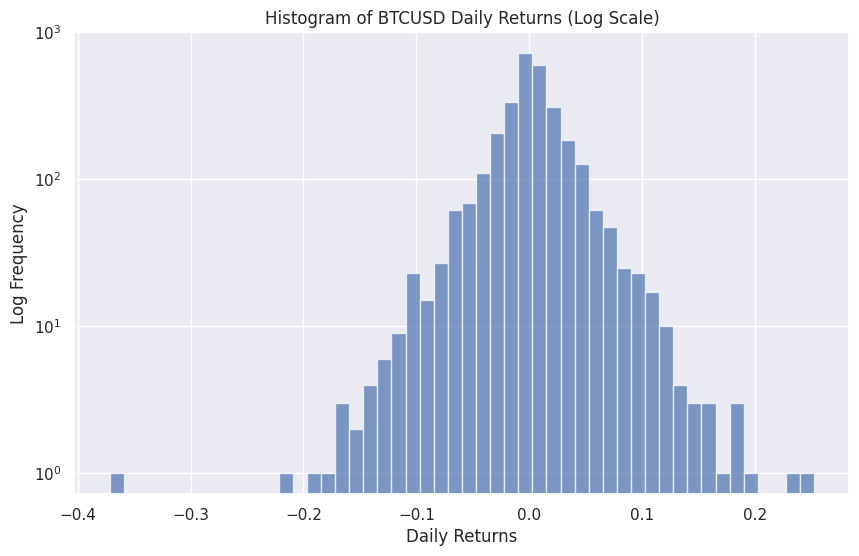

In [27]:
# Exercise 7
btcusd = yf.download("BTC-USD", start="2014-09-18", end="2022-12-31", auto_adjust=False)['Adj Close']
btcusd_returns = btcusd.pct_change().dropna()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(btcusd_returns, bins=50, log=True, alpha=0.7)
plt.xlabel('Daily Returns')
plt.ylabel('Log Frequency')
plt.title('Histogram of BTCUSD Daily Returns (Log Scale)')
plt.show()

Top 10 Worst Daily Returns:
1. -37.17%
2. -21.14%
3. -18.74%
4. -18.18%
5. -16.85%
6. -15.97%
7. -15.97%
8. -15.66%
9. -15.33%
10. -14.35%

Gaps between consecutive losses:
Gap between 1 and 2: 16.02%
Gap between 2 and 3: 2.40%
Gap between 3 and 4: 0.56%
Gap between 4 and 5: 1.32%
Gap between 5 and 6: 0.88%
Gap between 6 and 7: 0.01%
Gap between 7 and 8: 0.31%
Gap between 8 and 9: 0.33%
Gap between 9 and 10: 0.98%


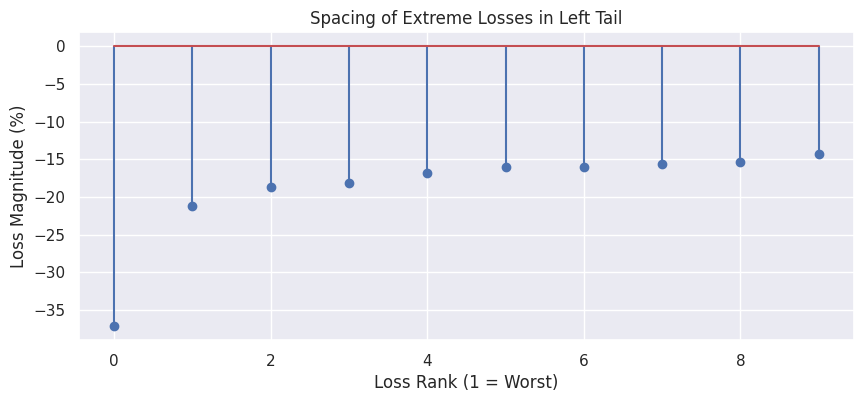

In [29]:
# Sort returns and get top 10 worst losses
if isinstance(btcusd_returns, pd.DataFrame):
    # If single-column DataFrame, convert to Series
    if len(btcusd_returns.columns) == 1:
        btcusd_returns = btcusd_returns.squeeze()
    else:
        # If multi-column, take first column (shouldn't happen for BTC-USD)
        btcusd_returns = btcusd_returns.iloc[:, 0]

# Now safely process as Series
sorted_returns = np.sort(btcusd_returns.values)  # Use .values to get NumPy array
worst_10 = sorted_returns[:10]

# Print worst returns
print("Top 10 Worst Daily Returns:")
for i, r in enumerate(worst_10, 1):
    print(f"{i}. {r*100:.2f}%")  # Now r is scalar float

# Calculate gaps between consecutive losses
gaps = np.diff(worst_10)
print("\nGaps between consecutive losses:")
for i, gap in enumerate(gaps, 1):
    print(f"Gap between {i} and {i+1}: {abs(gap)*100:.2f}%")

# Visualize tail spacing
plt.figure(figsize=(10, 4))
plt.stem(worst_10*100)  # use_line_collection deprecated in newer matplotlib
plt.title("Spacing of Extreme Losses in Left Tail")
plt.ylabel("Loss Magnitude (%)")
plt.xlabel("Loss Rank (1 = Worst)")
plt.grid(True)
plt.show()

### **7.3 Implementing Parametric VaR with $t$-distribution**

The Student's t-distribution is commonly used as an alternative to the normal distribution when modeling data with fat tails. The degrees of freedom parameter controls the heaviness of the tails. As the degrees of freedom increase, the t-distribution approaches the normal distribution. For smaller degrees of freedom (dof), the tails become heavier, indicating a higher probability of extreme values.

In [ ]:
# degrees of freedom

def getTVar(returns, dof, confidenceLevel):
    mean = returns.mean()
    std = returns.std()
    var = np.sqrt((dof - 2) / dof) * stats.t.ppf(1 - confidenceLevel, dof) * std + mean
    return (100 * var).round(3)

print(f"The parametric VaR using t-distribution with a confidence interval 0.9, is {getTVar(btcusd_returns, 5, 0.9)}% \n")
print(f"The parametric VaR using t-distribution with a confidence interval 0.95, is {getTVar(btcusd_returns, 5, 0.95)}% \n")
print(f"The parametric VaR using t-distribution with a confidence interval 0.99, is {getTVar(btcusd_returns, 5, 0.99)}% \n")

## **8. VaR Using Monte Carlo Simulation**

In the previous sections, we discussed how one can use historical data on financial series to compute the Value at Risk. But what if we have incomplete or insufficient data to do so? In this case, we can hypothesize a distribution that generates the data and run simulations using those distributional assumptions. This method is called *Monte Carlo VaR*.


The Monte Carlo VaR includes a series of simulations, where each return stream is represented as a random variable. This variable can be taken from any probability distribution, which is great because that means it doesn't necessarily assume a normal distribution. There is a lot of flexibility in choosing what kind of distribution to use. All the variables are then dollar-weighted and simulated to see what the total portfolio value is at the end of each run. These simulation returns are then sorted lowest to highest, and we can easily look to see what the Value at Risk is using similar computations to the historical method, except this time, we're using simulated returns instead of historical returns. For example, if you ran a series of 1,000 simulations, you would look at the 50th lowest value to determine the VaR for a 95% confidence interval.



Considerations for this method:
* Estimations will not be effective if the probability distributions used to determine the random variables are incorrect. Many use past data to get an idea of what the probability distribution should be; this method allows for some subjectivity.
* You can estimate VaR more effectively for portfolios containing options with this method versus the parametric method since Monte Carlo doesn't assume a normal distribution of returns.


In [ ]:
# Parameters
initial_investment = 100000  # Initial portfolio value (in dollars)
mean_return = 0.0005  # Daily mean return of the asset (e.g., 0.05%)
volatility = 0.02  # Daily volatility (not annual!) is 2%
days = 1  # 1 day time horizon
num_simulations = 10000  # Number of Monte Carlo simulations
confidence_level = 0.95  # Confidence level for VaR (e.g., 95%)

# Generate random returns based on normal distribution
np.random.seed(2024)  # For reproducibility
random_returns = np.random.normal(loc=mean_return * days, scale=volatility * np.sqrt(days), size=num_simulations)

# Calculate portfolio values at the end of the simulation
portfolio_end_values = initial_investment * (1 + random_returns)

# Calculate profit and loss (P&L)
portfolio_pnl = portfolio_end_values - initial_investment

# Calculate the VaR at the specified confidence level
VaR = np.percentile(portfolio_pnl, (1 - confidence_level) * 100)

# Output the results
print(f"Value at Risk (VaR) at {confidence_level * 100}% confidence level: -${abs(VaR):,.2f}")

#Plot the distribution of portfolio P&L
plt.figure(figsize=(10, 6))
plt.hist(portfolio_pnl, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=VaR, color='r', linestyle='dashed', linewidth=2)
plt.title(f"Monte Carlo Simulation of Portfolio P&L (VaR at {confidence_level * 100}% Confidence Level)")
plt.xlabel('Profit & Loss ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## **9. Conclusion**

In this lesson, we've introduced a wide range of important concepts in financial risk analysis. We started by examining different types of returns, including total returns, dividend-adjusted returns, and excess returns, which form the foundation for more advanced risk metrics. We then explored the Sharpe Ratio and showcased how important this ratio is in the portfolio management context.

The latter part of the lesson focused on downside risk metrics, particularly Value at Risk (VaR). We covered various methods for calculating VaR, including historical, parametric (with both normal and t-distributions), and Monte Carlo simulation approaches. We also introduced the concept of Conditional Value at Risk (CVaR) as an extension of VaR.

**References**

* Elton, Edwin J., et al. *Modern Portfolio Theory and Investment Analysis*. John Wiley & Sons, 2009.

* Engle, Robert. "GARCH 101: The Use of ARCH/GARCH Models in Applied Econometrics." *The Journal of Economic Perspectives*, vol. 15, no. 4, 2001, pp. 157–168.

---
Copyright 2024 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
